## **Visual Representation :**

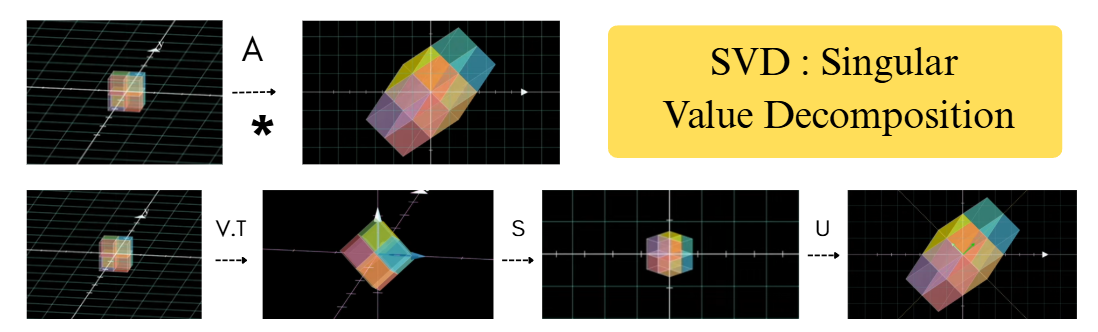

# **Recap: The Geometric Intuition of Singular Value Decomposition (SVD)**

Let's consider a matrix $A$ that transforms a specimen, for example, by squeezing a 3D object into a 2D space or stretching it along specific axes.

We can decompose this transformation into three distinct steps using **SVD**:
$$A = U \cdot \Sigma \cdot V^T$$

### **1. The Problem: Rectangular Matrices & Missing Eigenvectors**
If $A$ is a **rectangular matrix** (changing dimensions, e.g., from $N$ to $M$ dimensions), it becomes impossible to find standard eigenvalues and eigenvectors.
* *Why?* Eigenvectors require the input vector $x$ and output vector $Ax$ to be parallel ($Ax = \lambda x$). If the dimensions change, "pointing in the same direction" is impossible.
* *Consequence:* We cannot directly find the axis along which matrix $A$ stretches the specimen.

### **2. The Solution: The Symmetric Helper ($A^T A$)**
To solve this, we multiply $A$ by its transpose to create the matrix $A^T A$.
* **Symmetry:** $A^T A$ is always a square, symmetric matrix, regardless of the shape of $A$.
* **Properties:** Symmetric matrices always have orthogonal eigenvectors. These vectors allow us to find the **principal axes** of the input space.

### **3. Scaling: The "Square Root" Rule**
While $A^T A$ gives us the correct axes, it distorts the scale.
* Multiplying by $A^T$ essentially applies the transformation twice ($A$, then $A^T$).
* If $A$ stretches a vector by a factor of 3, $A^T A$ stretches it by $3^2 = 9$.
* **The Fix:** To find the true stretch of $A$ (the **Singular Values**), we take the square root of the eigenvalues of $A^T A$.

### **4. Changing the Basis ($V^T$)**
We cannot simply stretch the specimen along its original axes. We must first align the specimen with the axes defined by $A^T A$.
* This is why we need to change the **Basis** of the specimen.
* Ideally, we would apply an inverse operation to align the axes. However, because the eigenvectors are orthogonal, the transpose acts as the inverse ($V^T = V^{-1}$).
* This allows us to easily rotate the specimen's axis to match the axes of $A^T A$.

### **Summary of the Pipeline**
We can split any matrix (even rectangular ones) into these constituent geometric operations:

$$\text{Specimen Axis} \xrightarrow{\text{Rotate } (V^T)} \text{Aligned Axis} \xrightarrow{\text{Stretch } (\Sigma)} \text{Scaled Space} \xrightarrow{\text{Rotate } (U)} \text{Output Axis}$$

### **Uses in Image Compression**

Let's consider a grayscale image to be an $N \times M$ matrix.
* As discussed, the **Singular Values** ($\sigma$) in the diagonal matrix $\Sigma$ represent the "stretch" or magnitude of information along specific axes.
* In the context of an image, these values correspond to the **intensity of information** (or "energy") captured by that component.

**The Strategy:**
We can "toggle" the quality of the image by manipulating the $\Sigma$ matrix.
1.  Perform SVD on the image: $A = U \Sigma V^T$.
2.  **Truncate** the Diagonal Matrix: Keep the top $k$ largest singular values and set the rest to **zero**.
3.  **Reconstruct**: Multiply the matrices back together ($A_k = U \Sigma_k V^T$).

Since the smallest singular values often represent noise or very fine detail, zeroing them out compresses the image storage size while maintaining the overall structure.

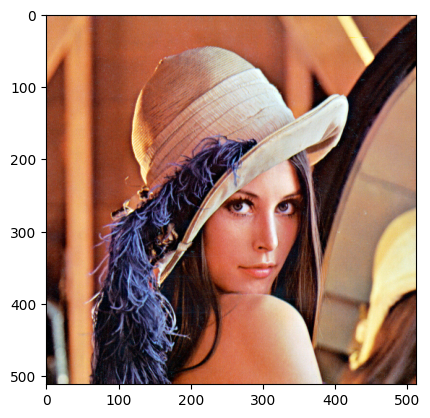

In [30]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img = cv.imread("Lena.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [31]:
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]

In [32]:
def compress(channel, k):
    U, S, Vt = np.linalg.svd(channel)
    Sk = np.diag(S[:k])
    compressed = U[:, :k] @ Sk @ Vt[:k, :]
    return compressed

In [45]:
k=12
Rcompressed = compress(R, k)
Gcompressed = compress(G, k)
Bcompressed = compress(B, k)

In [46]:
imgcompressed = np.dstack((Rcompressed, Gcompressed, Bcompressed))
imgcompressed = np.clip(imgcompressed, 0, 255).astype(np.uint8)

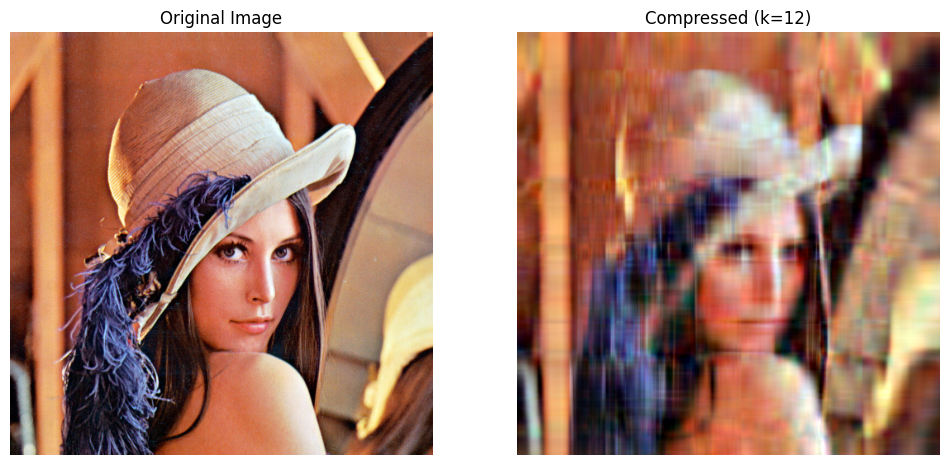

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(imgcompressed)
ax[1].set_title(f"Compressed (k={k})")
ax[1].axis('off')

plt.show()

# **Understanding PCA and Dimensionality Reduction via SVD**

**The Scenario:**
Let's assume we have a 2D plot of data points, and we want to reduce it to **1D** by projecting these points onto a single line.

**The Challenge: Which axis do we choose?**
* If we simply project everything onto the X-axis or Y-axis, we might lose crucial information.
* **Goal:** We must choose an axis where the data is most "spread out" (high variance). This ensures the points remain **differentiable** (distinguishable) after projection.

### **1. The Role of the Covariance Matrix ($A^T A$)**
Let $A$ be our data matrix. When we multiply $A^T A$ (often related to the **Covariance Matrix** if data is centered), we get a small square matrix that summarizes the relationships between our dimensions.

For a 2D dataset, $A^T A$ looks like this:
$$
A^T A = \begin{bmatrix}
\text{Var}(x) & \text{Covar}(x,y) \\
\text{Covar}(y,x) & \text{Var}(y)
\end{bmatrix}
$$

* **Diagonal Terms:** Represent the spread along the original X and Y axes.
* **Off-Diagonal Terms:** Represent the **Correlation**.
    * If the off-diagonal term (e.g., at index `[0,1]`) is **non-zero**, it means $x$ and $y$ are related. The "true" direction of the data is not horizontal or vertical, but **diagonal**.

### **2. Finding the "Hidden" Axis**
Since the data is diagonal, the standard axes $(1,0)$ and $(0,1)$ are no longer optimal. We need to find the specific vector that points along this diagonal spread.

* **The Eigenvector of $A^T A$:** This vector points exactly in the direction of the correlation (the widest spread of data).
* **The Eigenvalue:** This value tells us the *magnitude* of the spread along that vector.

### **3. Projection (2D $\to$ 1D)**
By finding the eigenvector corresponding to the **largest eigenvalue** (Principal Component 1), we identify the line that retains the most information.

**Conclusion:**
Instead of squashing data onto the X or Y axis, we project it onto this **Eigenvector**. This effectively reduces the dimensions from 2D to 1D while keeping the data points as distinguishable as possible.

In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
points = np.array([
    [1, 2],
    [3, 4],
    [5, 5],
    [6, 8]
])

In [52]:
meanval = np.mean(points, axis=0)
centered = points - meanval

In [53]:
U, S, Vt = np.linalg.svd(centered)
firstpc = Vt[0]

In [54]:
valuesatline = centered @ firstpc

In [55]:
print(valuesatline)

[-3.88133419 -1.05854569  1.0139187   3.92596117]


In [56]:
ponline = valuesatline[:, np.newaxis] * firstpc

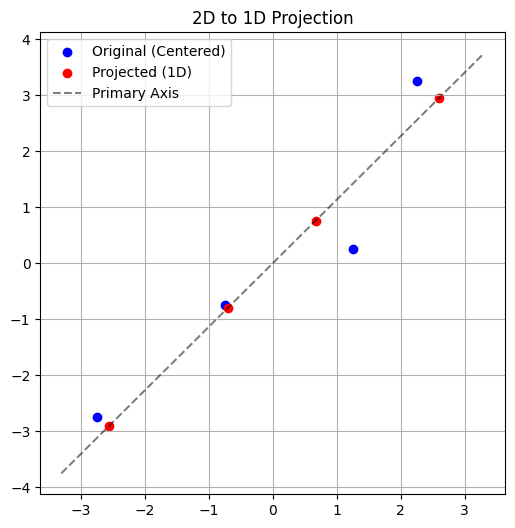

In [58]:
plt.figure(figsize=(6,6))
plt.scatter(centered[:,0], centered[:,1], label='Original (Centered)', color='blue')
plt.scatter(ponline[:,0], ponline[:,1], label='Projected (1D)', color='red')
plt.plot([-firstpc[0]*5, firstpc[0]*5],
         [-firstpc[1]*5, firstpc[1]*5], 'k--', alpha=0.5, label='Primary Axis')
plt.legend()
plt.grid(True)
plt.title("2D to 1D Projection")
plt.show()

### **References**
1.  Sanderson, G. (3Blue1Brown). *Essence of Linear Algebra*. [YouTube Series](https://www.youtube.com/watch?v=kjBOesZCoqc).
2.  Levey, S. *The Matrix Transpose: Visual Intuition*. [YouTube Video](https://www.youtube.com/watch?v=wjYpzkQoyD8).
3.  Visual Kernel. *SVD Visualized, Singular Value Decomposition explained*. [YouTube Video](https://www.youtube.com/watch?v=vSczTbgc8Rc).